In [1]:

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [2]:
# Download stopwords if you haven't already
nltk.download('stopwords')

# Load your data (replace 'Reviews.csv' with your actual file path)
data = pd.read_csv(r'C:\Users\masha\git\NEEC\Reviews.csv')

# Filter profiles and perform preprocessing as per your original process
profile_counts = data['ProfileName'].value_counts()
valid_profiles = profile_counts[profile_counts >= 100].index
filtered_df = data[data['ProfileName'].isin(valid_profiles)]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Classify scores into positive/negative
def classify_score(score):
    if score < 3:
        return 0
    else:
        return 1

In [4]:
actualScore = filtered_df['Score']
positiveNegative = actualScore.map(classify_score)
filtered_df.loc[:, 'Score'] = positiveNegative

sorted_data = filtered_df.sort_values('ProfileName', axis=0, ascending=True)
sorted_data.head

<bound method NDFrame.head of             Id   ProductId          UserId                        ProfileName  \
42626    42627  B001EQ4E60    ACYR6O588USK  '  Groovin' guy "music historian"   
539539  539540  B006WYSFZK    ACYR6O588USK  '  Groovin' guy "music historian"   
134696  134697  B003ZXHDGS    ACYR6O588USK  '  Groovin' guy "music historian"   
564538  564539  B002K74V3S    ACYR6O588USK  '  Groovin' guy "music historian"   
228736  228737  B0058AMY10    ACYR6O588USK  '  Groovin' guy "music historian"   
...        ...         ...             ...                                ...   
12835    12836  B000YV7WBU  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
554169  554170  B000LKTKZ0  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
420739  420740  B001EQ5GG2  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
288466  288467  B000ENUC3S  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
482302  482303  B0018KLPFK  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"  

In [5]:
# removing duplicate entries
final = sorted_data.drop_duplicates(subset={"UserId", "ProfileName" ,"Time", "Text"}, keep = 'first', inplace = False)
print(final["Score"])

42626     1
539539    1
134696    1
564538    1
71087     1
         ..
200902    1
321641    1
12835     1
554169    1
420739    1
Name: Score, Length: 16068, dtype: int64


In [6]:
# Separate positive and negative samples
positive_samples = final[final['Score'] == 1]
negative_samples = final[final['Score'] == 0]

print(positive_samples, negative_samples)

            Id   ProductId          UserId                        ProfileName  \
42626    42627  B001EQ4E60    ACYR6O588USK  '  Groovin' guy "music historian"   
539539  539540  B006WYSFZK    ACYR6O588USK  '  Groovin' guy "music historian"   
134696  134697  B003ZXHDGS    ACYR6O588USK  '  Groovin' guy "music historian"   
564538  564539  B002K74V3S    ACYR6O588USK  '  Groovin' guy "music historian"   
71087    71088  B004IN7CJ2    ACYR6O588USK  '  Groovin' guy "music historian"   
...        ...         ...             ...                                ...   
200902  200903  B000JJK0B6  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
321641  321642  B001GQ3E3M  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
12835    12836  B000YV7WBU  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
554169  554170  B000LKTKZ0  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
420739  420740  B001EQ5GG2  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   

        HelpfulnessNumerato

In [7]:
# Randomly sample from positive samples to match the number of negative samples
positive_sampled = positive_samples.sample(n=len(negative_samples), random_state=42)

In [8]:
# Combine the sampled positive samples with the negative samples
balanced_df = pd.concat([positive_sampled, negative_samples])

In [9]:
# Shuffle the dataset to mix positive and negative samples
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
# Display the counts after balancing
score_counts_balanced = balanced_df['Score'].value_counts()
print("Score Counts after sampling:", score_counts_balanced)

final = balanced_df

final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
print(final.shape)

score_counts = final['Score'].value_counts()

Score Counts after sampling: Score
1    2057
0    2057
Name: count, dtype: int64
(4114, 10)


In [11]:
# Preprocess the text data
stop = set(stopwords.words('english'))  # Set of stopwords
sno = SnowballStemmer('english')  # Initialize Snowball Stemmer

# Function to clean HTML tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    return re.sub(cleanr, ' ', sentence)

# Function to remove punctuation
def cleanpunc(sentence):
    return re.sub(r'[?|!|\'|"|#]', r'', sentence)

# Preprocess the 'Text' column
final_string = []
list_of_sent = []

for sent in final['Text']:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_word in cleanpunc(w).split():
            if cleaned_word.isalpha() and len(cleaned_word) > 2:
                word_lower = cleaned_word.lower()
                if word_lower not in stop:
                    stemmed_word = sno.stem(word_lower)
                    filtered_sentence.append(stemmed_word)
    list_of_sent.append(filtered_sentence)
    final_string.append(" ".join(filtered_sentence))

In [12]:
# Add the cleaned text back into the DataFrame
final['CleanedText'] = final_string

In [13]:
from gensim.models import Word2Vec
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

Number of clusters: 10, Silhouette Score: 0.20
Number of clusters: 9, Silhouette Score: 0.21
Number of clusters: 8, Silhouette Score: 0.21
Number of clusters: 7, Silhouette Score: 0.22
Number of clusters: 6, Silhouette Score: 0.23
Number of clusters: 5, Silhouette Score: 0.24
Number of clusters: 4, Silhouette Score: 0.23
Number of clusters: 3, Silhouette Score: 0.26
Number of clusters: 2, Silhouette Score: 0.26


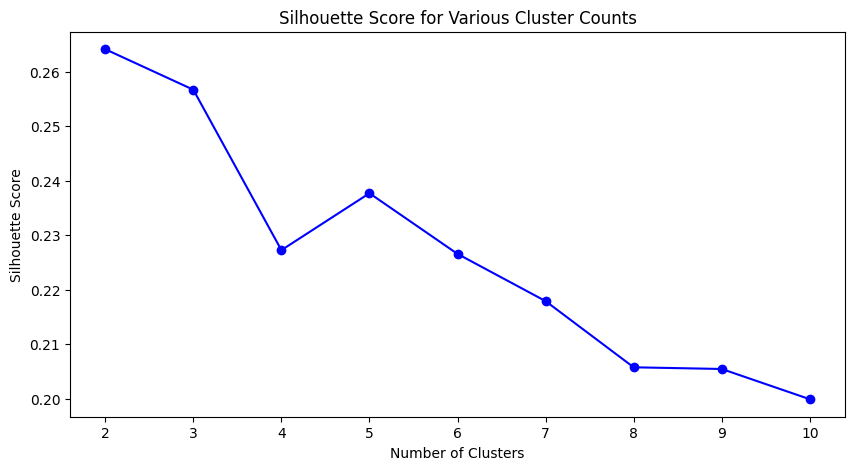

Best number of clusters: 2 with Silhouette Score: 0.26


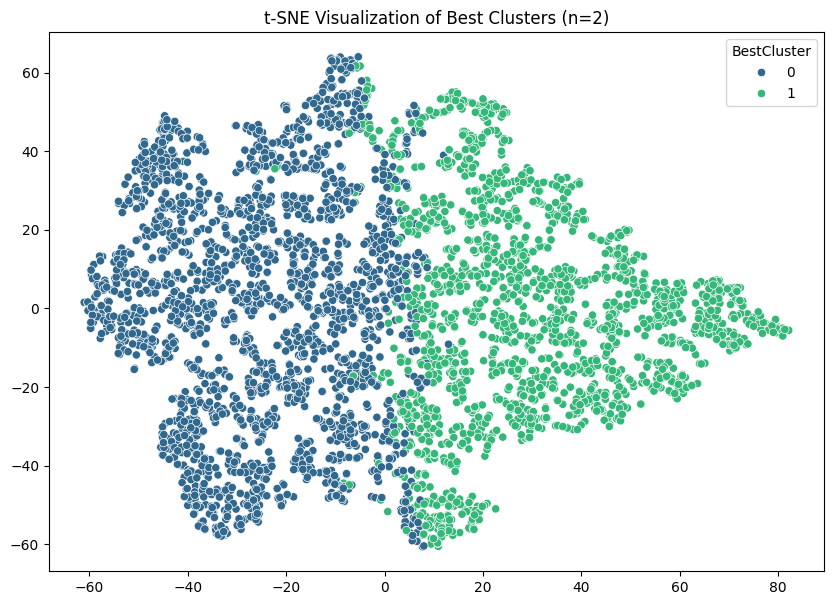

In [14]:
# Sample DataFrame setup (replace this with your actual data loading process)
# final = pd.DataFrame(...) 

# Step 1: Tokenize cleaned text for Word2Vec training
final['TokenizedText'] = final['CleanedText'].apply(lambda x: x.split())

# Step 2: Train Word2Vec model on tokenized text
word2vec_model = Word2Vec(sentences=final['TokenizedText'], vector_size=100, window=5, min_count=2, workers=4)

# Step 3: Generate review embeddings by averaging word vectors
def get_review_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

final['ReviewEmbedding'] = final['TokenizedText'].apply(lambda tokens: get_review_embedding(tokens, word2vec_model))
review_embeddings = np.vstack(final['ReviewEmbedding'].values)

# Step 4: Cluster review embeddings and evaluate clusters for each number of clusters from 10 to 2
silhouette_scores = {}
for num_clusters in range(10, 1, -1):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    final['Cluster'] = kmeans.fit_predict(review_embeddings)

    # Evaluate clustering quality with silhouette score
    silhouette_avg = silhouette_score(review_embeddings, final['Cluster'])
    silhouette_scores[num_clusters] = silhouette_avg
    print(f'Number of clusters: {num_clusters}, Silhouette Score: {silhouette_avg:.2f}')

# Visualize the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Various Cluster Counts')
plt.show()

# Optional: Visualize the best cluster count based on silhouette scores
best_num_clusters = max(silhouette_scores, key=silhouette_scores.get)
print(f'Best number of clusters: {best_num_clusters} with Silhouette Score: {silhouette_scores[best_num_clusters]:.2f}')

# Step 6: Visualize clusters with t-SNE for the best cluster count
best_kmeans = KMeans(n_clusters=best_num_clusters, random_state=42)
final['BestCluster'] = best_kmeans.fit_predict(review_embeddings)

tsne = TSNE(n_components=2, random_state=42)
review_embeddings_2d = tsne.fit_transform(review_embeddings)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=review_embeddings_2d[:, 0], y=review_embeddings_2d[:, 1], hue=final['BestCluster'], palette="viridis")
plt.title(f"t-SNE Visualization of Best Clusters (n={best_num_clusters})")
plt.show()

In [15]:
from collections import Counter

# Set the number of clusters to 2 for a specific summary
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
final['Cluster'] = kmeans.fit_predict(review_embeddings)

# Step 1: Generate word frequencies for each cluster
cluster_summaries = {}
for cluster_num in range(num_clusters):
    cluster_data = final[final['Cluster'] == cluster_num]
    
    # Flatten all words in TokenizedText for this cluster and count occurrences
    words = [word for tokens in cluster_data['TokenizedText'] for word in tokens]
    word_counts = Counter(words).most_common(10)  # Top 10 most common words
    
    # Step 2: Count positive and negative reviews
    positive_reviews = cluster_data[cluster_data['Score'] == 1].shape[0]
    negative_reviews = cluster_data[cluster_data['Score'] == 0].shape[0]
    
    # Step 3: Sample reviews (3 positive, 3 negative if available)
    sample_reviews = pd.concat([
        cluster_data[cluster_data['Score'] == 1].sample(3, random_state=42),
        cluster_data[cluster_data['Score'] == 0].sample(3, random_state=42)
    ], axis=0)
    
    # Save the summary
    cluster_summaries[cluster_num] = {
        'most_common_words': word_counts,
        'positive_reviews': positive_reviews,
        'negative_reviews': negative_reviews,
        'sample_reviews': sample_reviews[['Text', 'Score']]
    }

# Print the summaries
for cluster_num, summary in cluster_summaries.items():
    print(f"Cluster {cluster_num} Summary:")
    print(f"Most common words: {summary['most_common_words']}")
    print(f"Positive reviews: {summary['positive_reviews']}, Negative reviews: {summary['negative_reviews']}")
    print("Sample reviews:")
    print(summary['sample_reviews'])
    print("\n" + "="*50 + "\n")

Cluster 0 Summary:
Most common words: [('like', 1433), ('tast', 1215), ('one', 827), ('flavor', 781), ('would', 705), ('good', 672), ('tri', 661), ('product', 652), ('use', 638), ('get', 571)]
Positive reviews: 1118, Negative reviews: 1129
Sample reviews:
                                                   Text  Score
3605  Does not replace powder but i find they are co...      1
356   Sonic is my favorite out of the Drink Neuro fa...      1
1638  Been drinking this tea for about a year.  Help...      1
2753  I plain just don't like these fruit snacks. Te...      0
3691  Looks like a very nice basket full of dark cho...      0
4100  I tried this because I had been reading it wou...      0


Cluster 1 Summary:
Most common words: [('like', 1101), ('tast', 827), ('use', 675), ('one', 673), ('flavor', 634), ('product', 615), ('good', 565), ('tri', 552), ('make', 539), ('tea', 536)]
Positive reviews: 939, Negative reviews: 928
Sample reviews:
                                                 

In [16]:
from collections import Counter



Cluster 0 Summary:
Most common words: [('like', 1433), ('tast', 1215), ('one', 827), ('flavor', 781), ('would', 705), ('good', 672), ('tri', 661), ('product', 652), ('use', 638), ('get', 571)]
Positive reviews: 1118, Negative reviews: 1129
Sample reviews:
                                                Text  Score
0  Sampled this product and found them in my loca...      1
2  Quality  of this product is good, my only issu...      0
3  My dogs absolutely love the liver-flavor bone....      1

Cluster 1 Summary:
Most common words: [('like', 1101), ('tast', 827), ('use', 675), ('one', 673), ('flavor', 634), ('product', 615), ('good', 565), ('tri', 552), ('make', 539), ('tea', 536)]
Positive reviews: 939, Negative reviews: 928
Sample reviews:
                                                Text  Score
1  MIO "Peach Tea" has good sweetness and good fl...      1
4  The gum that says 'new' is not the same as the...      0
6  This is a extremely tasty drink, but I am part...      1


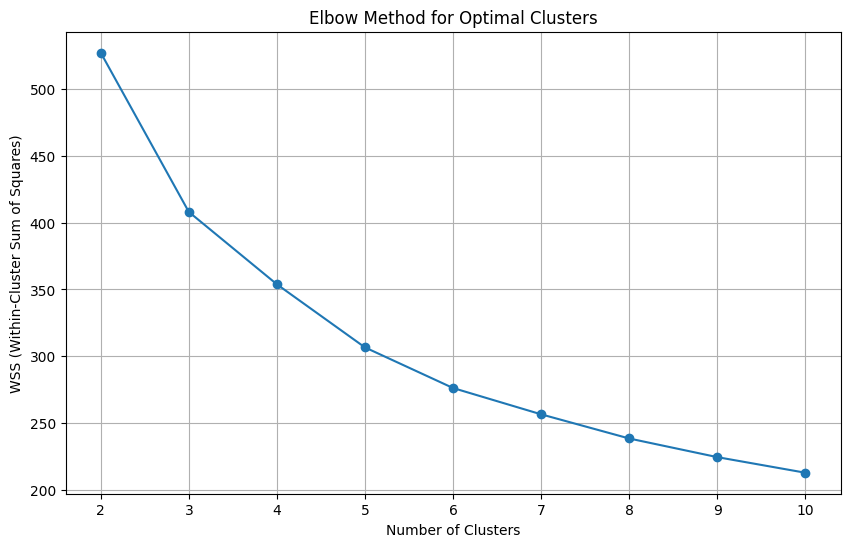

In [17]:
# Step 7: Analyze clusters
for cluster_num in range(num_clusters):
    print(f"\nCluster {cluster_num} Summary:")
    
    # Most common words in each cluster
    cluster_reviews = final[final['Cluster'] == cluster_num]
    cluster_words = " ".join(cluster_reviews['CleanedText'])
    word_counts = Counter(cluster_words.split())
    most_common_words = word_counts.most_common(10)
    print(f"Most common words: {most_common_words}")
    
    # Count positive and negative reviews
    pos_reviews = cluster_reviews[cluster_reviews['Score'] == 1].shape[0]
    neg_reviews = cluster_reviews[cluster_reviews['Score'] == 0].shape[0]
    print(f"Positive reviews: {pos_reviews}, Negative reviews: {neg_reviews}")
    
    # Sample a few reviews from each cluster for inspection
    print("Sample reviews:")
    print(cluster_reviews[['Text', 'Score']].head(3))  # Display top 3 sample reviews

# Step 8: Optional - Visualize WSS (Within-Cluster Sum of Squares) for Elbow Method
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import pairwise_distances_argmin_min

# Calculate WSS for different cluster sizes (if re-tuning the number of clusters)
wss_values = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(review_embeddings)
    wss = kmeans_temp.inertia_
    wss_values.append(wss)

# Plot WSS to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wss_values, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

In [18]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

c:\Users\masha\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [20]:
# Function to create BERT embeddings
def get_bert_embedding(text):
    # Tokenize and encode the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():  # Disable gradient calculations for efficiency
        outputs = model(**inputs)
        # Use the [CLS] token's embedding for the whole sentence representation
        cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
    return cls_embedding.squeeze()

In [ ]:
# Generate embeddings for each review and store them in a list
final['BERT_Embedding'] = final['CleanedText'].apply(get_bert_embedding)

In [ ]:
# Stack embeddings into a single matrix for clustering
review_embeddings = np.vstack(final['BERT_Embedding'].values)

In [ ]:
# Step 4: Cluster review embeddings and evaluate clusters for each number of clusters from 10 to 2
silhouette_scores = {}
for num_clusters in range(10, 1, -1):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    final['Cluster'] = kmeans.fit_predict(review_embeddings)

    # Evaluate clustering quality with silhouette score
    silhouette_avg = silhouette_score(review_embeddings, final['Cluster'])
    silhouette_scores[num_clusters] = silhouette_avg
    print(f'Number of clusters: {num_clusters}, Silhouette Score: {silhouette_avg:.2f}')

In [ ]:
# Visualize the silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Various Cluster Counts')
plt.show()

In [ ]:
# Find the best number of clusters based on silhouette scores
best_num_clusters = max(silhouette_scores, key=silhouette_scores.get)
print(f'Best number of clusters: {best_num_clusters} with Silhouette Score: {silhouette_scores[best_num_clusters]:.2f}')

In [ ]:
# Apply KMeans clustering with the optimal number of clusters
best_kmeans = KMeans(n_clusters=best_num_clusters, random_state=42)
final['BestCluster'] = best_kmeans.fit_predict(review_embeddings)

In [ ]:
# Step 6: Visualize clusters with t-SNE for the best cluster count
tsne = TSNE(n_components=2, random_state=42)
review_embeddings_2d = tsne.fit_transform(review_embeddings)

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=review_embeddings_2d[:, 0], y=review_embeddings_2d[:, 1], hue=final['BestCluster'], palette="viridis")
plt.title(f"t-SNE Visualization of Best Clusters (n={best_num_clusters})")
plt.show()

In [ ]:
# Cluster summaries similar to your previous code
from collections import Counter

In [ ]:
cluster_summaries = {}
for cluster_num in range(best_num_clusters):
    cluster_data = final[final['BestCluster'] == cluster_num]
    
    # Flatten all words in TokenizedText for this cluster and count occurrences
    words = [word for tokens in cluster_data['TokenizedText'] for word in tokens]
    word_counts = Counter(words).most_common(10)  # Top 10 most common words
    
    # Count positive and negative reviews
    positive_reviews = cluster_data[cluster_data['Score'] == 1].shape[0]
    negative_reviews = cluster_data[cluster_data['Score'] == 0].shape[0]
    
    # Sample reviews (3 positive, 3 negative if available)
    sample_reviews = pd.concat([
        cluster_data[cluster_data['Score'] == 1].sample(3, random_state=42),
        cluster_data[cluster_data['Score'] == 0].sample(3, random_state=42)
    ], axis=0)
    
    # Save the summary
    cluster_summaries[cluster_num] = {
        'most_common_words': word_counts,
        'positive_reviews': positive_reviews,
        'negative_reviews': negative_reviews,
        'sample_reviews': sample_reviews[['Text', 'Score']]
    }

NameError: name 'best_num_clusters' is not defined

In [ ]:
# Print the summaries
for cluster_num, summary in cluster_summaries.items():
    print(f"Cluster {cluster_num} Summary:")
    print(f"Most common words: {summary['most_common_words']}")
    print(f"Positive reviews: {summary['positive_reviews']}, Negative reviews: {summary['negative_reviews']}")
    print("Sample reviews:")
    print(summary['sample_reviews'])
    print("\n" + "="*50 + "\n")